<a href="https://colab.research.google.com/github/grantinator/colab/blob/main/infini_gram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset (names dataset)

In [3]:
!wget https://raw.githubusercontent.com/exanova-y/von_neumann_dataset/refs/heads/main/biography.txt -O corpus.txt

--2025-07-24 01:49:26--  https://raw.githubusercontent.com/exanova-y/von_neumann_dataset/refs/heads/main/biography.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 747769 (730K) [text/plain]
Saving to: ‘corpus.txt’

corpus.txt          100%[===================>] 730.24K  --.-KB/s    in 0.04s   

2025-07-24 01:49:27 (20.0 MB/s) - ‘corpus.txt’ saved [747769/747769]



In [51]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import re

raw_corpus = open("corpus.txt", "r").read()

### Corpus class
* Allows you to pull out the first n tokens (words).


In [66]:
import re

class Corpus:
  def __init__(self, raw_corpus):
    self.raw_corpus = raw_corpus
    # maps nth word : index in self.corpus that slices upto and including that word.
    self.word_end_index = {}
    self.corpus = self._clean()

  def get_words(self):
    return self.corpus.split(' ')

  def get_vocab(self):
    return set(self.get_words())

  def get_vocab_size(self):
    return len(self.get_vocab())

  def get_corpus(self):
    return self.corpus

  def truncate_to(self, n_words):
    words = self.get_words()[:n_words] # already cleaned from initial init.
    self.corpus = ' '.join(words)
    self.raw_corpus = corpus

    for i, token in enumerate(words):
      if i == 0:
        self.word_end_index[i] = len(token) - 1
      else:
        self.word_end_index[i] = self.word_end_index[i - 1] + len(token) + 1
    return self


  def _clean(self):
    tokens = []
    # Break into tokens
    for line in raw_corpus.splitlines():
      if len(line) == 0:
        continue

      line = line.split(' ')
      tokens.extend(line)

    # Clean/normalize individual tokens
    cleaned_tokens = []
    for i, token in enumerate(tokens):
      token = token.lower()
      token = token.strip()
      # Strip punctuation
      token = re.sub(r'[^a-zA-Z]', '', token)

      if len(token) > 0:
        cleaned_tokens.append(token)

    for i, token in enumerate(cleaned_tokens):
      if i == 0:
        self.word_end_index[i] = len(token) - 1
      else:
        self.word_end_index[i] = self.word_end_index[i - 1] + len(token) + 1 # count space inbetween.

    return ' '.join(cleaned_tokens)

  def get_first_n_words(self, n):
    return self.corpus[:self.word_end_index[n]+1]

In [67]:
corpus = Corpus(raw_corpus)
corpus.get_first_n_words(7)

'contents introduction who was john von neumann made'

In [68]:
corpus.truncate_to(1000)
corpus.get_first_n_words(7)

'contents introduction who was john von neumann made'

In [69]:
words = corpus.get_words()
vocab = corpus.get_vocab()
word_to_ix = {w: i for i, w in enumerate(vocab)}
word_to_ix['<UNK>'] = len(vocab)
ix_to_word = {i: w for w, i in word_to_ix.items()}

## SuffixArray class
* Builds the suffix arrays by mapping `[(suffix, startIndex)]`
* For an ngram, finds all (suffix, startIndex) pars where the suffix begins with the given ngram.

In [70]:
class SuffixArray:
  def __init__(self, corpus):
    self.corpus = corpus
    self.suffixes = []
    self._build()

  def _build(self):
    words = self.corpus.get_words()
    suffix = ''
    suffixes_with_index = []
    n = len(self.corpus.get_corpus())
    for word in words[::-1]:
      suffix = word.lower() + ' ' + suffix
      suffixes_with_index.append((suffix, n - len(suffix)))

    # Sort on the suffix
    sorted_suffixes = sorted(suffixes_with_index, key=lambda x: x[0])
    self.suffixes = sorted_suffixes

  def find_ngram_occurrences(self, ngram):
    """
    Find all suffixes that start with this prefix. Basically a lexicographical search
    over suffixes.
    """
    ngram = ngram.lower()
    suffixes = self.suffixes # starting indexes
    text = self.corpus.get_corpus()

    def getLowerBound():
      low, high = 0, len(suffixes) - 1

      while low <= high:
        mid = (low + high) // 2

        midSuffix = suffixes[mid][0]

        if midSuffix < ngram:
          low = mid + 1
        else:
          high = mid - 1
      return low

    def getUpperBound():
      low, high = 0, len(suffixes) - 1
      # Hack from chatgpt. If we just use ngram in the high search then ngram = "von neumann"
      # we would not count "von neumann made" as a match. But instead we add the max ascii char
      # so "von neuamnn + <anything>" < high_ngram and is counted.
      highNgram = ngram + chr(255)

      while low <= high:
        mid = (low + high) // 2

        midSuffix = suffixes[mid][0]

        if midSuffix < highNgram:
          low = mid + 1
        else:
          high = mid - 1
      return low

    upperBound = getUpperBound()
    lowerBound = getLowerBound()
    return suffixes[lowerBound:upperBound]

## InfiniGram class
* Returns a Counter for next word given a prefix.


In [71]:
from collections import Counter

class InfiniGram:
  def __init__(self, corpus):
    self.corpus = corpus
    self.suffixArray = SuffixArray(self.corpus)

  def get_next_word(self, prefix, suffixIndex):
    corpus_text = self.corpus.get_corpus()
    if not corpus_text[suffixIndex:].lstrip().startswith(prefix):
        return None

    # Move to the end of the current suffix.
    i = suffixIndex + len(prefix)
    while i < len(corpus_text) and corpus_text[i] != ' ':
      i += 1

    # i points to the space ending the suffix word now.
    i += 1

    # Eat up the next word to return.
    j = i
    while j < len(corpus_text) and corpus_text[j] != ' ':
      j += 1


    return corpus_text[i:j]

  def predict_next(self, prefix):
    """
    Returns a distribution across the entire vocab.
    """
    suffixes = self.suffixArray.find_ngram_occurrences(prefix)

    candidates = []

    for suffixText, startIndex in suffixes:
      nextWord = self.get_next_word(prefix, startIndex)

      if nextWord:
        candidates.append(nextWord)

    distribution = [0] * self.corpus.get_vocab_size()
    counts = Counter(candidates)

    total = sum(counts.values())

    for word, count in counts.items():
      distribution[word_to_ix[word]] = count / total

    return torch.tensor(distribution)

  def predict_next_word(self, prefix, top_k=5):
    predictions = self.predict_next(prefix)

    indices = torch.topk(predictions, top_k).indices
    return [ix_to_word[i.item()] for i in indices]

In [72]:
ig = InfiniGram(corpus)

In [73]:
ig.predict_next_word('the')

['worlds', 'sea', 'world', 'would', 'manhattan']

In [ ]:
ig.predict_next('the')

In [ ]:
ig.predict_next_word('the')

'manhattan '

# MLP *Impl*

In [75]:
class MLP:

  def __init__(self, vocab_size, n_embd, n_hidden, block_size):
    self.vocab_size = vocab_size
    self.n_embd = n_embd # dimensionality of each char's embedding
    self.n_hidden = n_hidden # the number of neurons in the hidden layer
    self.block_size = block_size # number of words in input layer
    self.C = torch.randn((vocab_size, n_embd))
    self.layers = [
        Linear(n_embd * block_size, n_hidden), Tanh(),
        Linear(n_hidden, n_hidden), Tanh(),
        Linear(n_hidden, n_hidden), Tanh(),
        Linear(n_hidden, n_hidden), Tanh(),
        Linear(n_hidden, n_hidden), Tanh(),
        Linear(n_hidden, vocab_size)
    ]
    self.parameters = [p for layer in self.layers for p in layer.parameters()]
    self.set_up()


  def set_up(self):
    with torch.no_grad():
      # last layer: make it less confident (for initialization make it closer to uniform distribution)
      self.layers[-1].weight *= 0.1
      for layer in self.layers[:-1]:
        if isinstance(layer, Linear):
          layer.weight *= (5/3) #(5/3) # kaiming init to make X @ W activations more unit normal at start

    for p in self.parameters:
      p.requires_grad = True

  def forward(self, Xb, y):
    emb = self.C[Xb]
    emb.view(emb.shape[0], -1)

    for layer in self.layers:
      x = layer(x)

    return F.cross_entropy(x, y)

  def predict(self, x):
    with torch.no_grad():
      emb = self.C[x]
      emb.view(emb.shape[0], -1)
      x = emb
      for layer in self.layers:
        # print(f"Multiplying x@W {x.shape} x {layer.weight.shape}")
        try:
          x = layer(x)
        except Exception as e:
          print(f"Exception:\n {e}")

      return F.softmax(x, dim=1).squeeze(0)

In [76]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt


def build_dataset(dataset):
  X, Y = [], []
  context = [0] * block_size
  for i in range(len(dataset) - block_size):
    context = [word_to_ix[w] for w in dataset[i:i+block_size]]
    y = word_to_ix[dataset[i+block_size]]
    X.append(context)
    Y.append(y)

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X,Y

## Layer definitions

In [77]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # khaming init or whatever its called. Prescale the weights so that when we do X @ W the activations are unit normal.
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if not self.bias is None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained) as part of gamma * batchNorm + beta to be learned
    # Start at 1 and zero so initialized values are unit normal but gamma and beta
    # can be learned away from forcing activations to unit normal
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # running mean and variance for predictions
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # mean for each neuron across all examples
      xvar = x.var(0, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # batch norm formula [https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html]
    self.out = self.gamma * xhat + self.beta
    # Update running mean/std if in traning mode
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

# Mixed Model

**mixture model**

In [87]:
class MixedInfiniGram:
  def __init__(self, n_embd, n_hidden, block_size, corpus):
    self.text = corpus.get_corpus()
    self.infinigram = InfiniGram(corpus)
    self.mlp = MLP(corpus.get_vocab_size(), n_embd, n_hidden, block_size)

  def predict_next(self, prefix, gamma=0.8):
    infinigram_predictions = self.infinigram.predict_next(prefix)

    x_ix = torch.tensor(word_to_ix[prefix]).unsqueeze(0)
    mlp_probs = self.mlp.predict(x_ix)

    mixed_probs = gamma * infinigram_predictions + (1 - gamma) * mlp_probs

    return [ix_to_word[ix.item()] for ix in torch.topk(mixed_probs, 5).indices]

  @property
  def layers(self):
    return self.mlp.layers

  @property
  def parameters(self):
    return self.mlp.parameters

# Prediction

In [88]:
# Params
text = corpus.get_corpus()
vocab = corpus.get_vocab()
vocab_size = corpus.get_vocab_size()
n_embd = 10 # dimensionality of each char's embedding
n_hidden = 100 # the number of neurons in the hidden layer
block_size = 1 # number of words in input layer

X, Y = build_dataset(words)
model = MixedInfiniGram(n_embd, n_hidden, block_size, corpus)

## 1. Train MLP

In [89]:
NUM_TRAINING_ITERS = 200
batch_size = 32
lossi = []
beta1 = 0.9
beta2 = 0.999

# batchnorm stuff, maybe remove
mu_i = [torch.zeros_like(p) for p in model.parameters]
v_i = [torch.zeros_like(p) for p in model.parameters]

eps = 1e-8

In [90]:
for epoch in range(NUM_TRAINING_ITERS):
  t = epoch + 1
  # Construct minibatch
  ix = torch.randint(0, X.shape[0], (batch_size,))
  Xb, Yb = X[ix], Y[ix]

  #forward pass
  # --------------------------------------------
  emb = model.mlp.C[Xb]
  x = emb.view(emb.shape[0], -1) # concatenate embeddigns into n_sample vectors of vocab * dim_size
  for layer in model.layers:
    x = layer(x)

  loss = F.cross_entropy(x, Yb) # loss function

  # loss = model(Xb, Yb)

  # model.zero_grads()
  for layer in model.layers:
    layer.out.retain_grad()

  for p in model.parameters:
    p.grad = None

  loss.backward()

  # lr = 0.1 if i < 100000 else 0.01
  lr = 0.001
  for i, p in enumerate(model.parameters):
    mt = beta1 * mu_i[i] + (1-beta1) * p.grad
    vt = beta2 * v_i[i] + (1-beta2) * p.grad**2

    mu_i[i] = mt # setting moving average to latest average
    v_i[i] = vt

    # Correct terms
    muhat = mt / (1 - beta1**t)
    vhat = vt / (1 - beta2**t)

    denom = torch.sqrt(vhat) + eps
    update = muhat / denom
    # p.data += -lr * p.grad
    p.data += -lr * (muhat / (vhat**0.5 + eps))

  if t % 10000 == 0:
    print(f"{t:7d}/{NUM_TRAINING_ITERS}: {loss.item():.4f}")


  # Track stats
  lossi.append(loss.log10().item())

In [ ]:
# plt.plot(torch.arange(len(lossi)), lossi) # Uncomment for loss plot

## 2. Predict

In [91]:
model.predict_next("the")

['manhattan', 'same', 'mathematical', 'worlds', 'sea']

# Prediction method

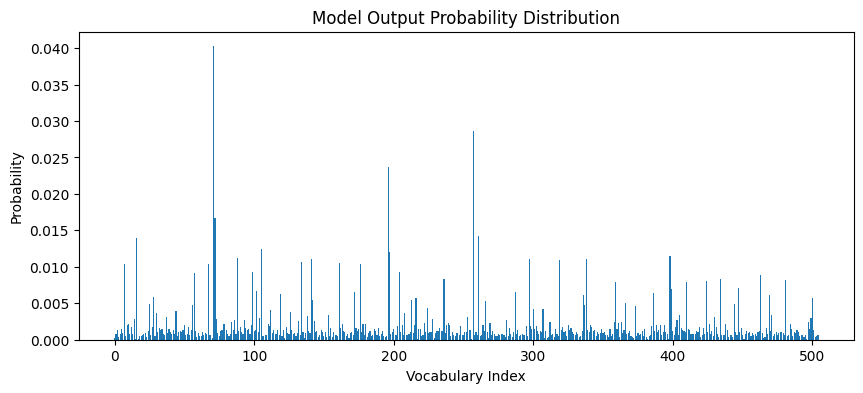

In [ ]:
npp = probs.squeeze(0).detach().numpy() # [1, 505] -> 505
plt.figure(figsize=(10, 4))
plt.bar(range(len(npp)), npp)
plt.title("Model Output Probability Distribution")
plt.xlabel("Vocabulary Index")
plt.ylabel("Probability")
plt.show()

# Regex based counter

In [64]:
def count_next_words(prefix, text):
  pattern = pattern = re.compile(rf'\b{re.escape(prefix)}\s+(\w+)', re.IGNORECASE)
  matches = pattern.findall(text)
  return Counter(matches)

count_next_words('the', corpus.get_first_n_words(1000)).most_common()

[('quantum', 1),
 ('super', 1),
 ('convoluted', 1),
 ('modern', 1),
 ('think', 1),
 ('sea', 1),
 ('rise', 1),
 ('replicators', 1),
 ('man', 1)]